In [269]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,KFold,GridSearchCV
from sklearn.metrics import accuracy_score,fbeta_score,f1_score
import numpy as np
import matplotlib.pyplot as plt
from helpers import make_complexity_curve, make_learning_curve,make_timing_curve,make_timing_curve_fixed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load Adult Data**

In [325]:
adult_df = pd.read_csv(filepath_or_buffer="adult_cleaned.csv")
adult_df_dummies = pd.get_dummies(adult_df.drop('target', 1))
adult_x = adult_df_dummies.copy().values
adult_y = adult_df["target"].copy().values
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(adult_x, adult_y, test_size=0.2,random_state=0)
print(f"adult_df: {adult_df.shape}")
print(f"X_adult_train: {X_adult_train.shape}")
print(f"X_adult_test: {X_adult_test.shape}")
print(f"y_adult_train: {y_adult_train.shape}")
print(f"y_adult_test: {y_adult_test.shape}")
print(f"y_adult_train pos: {(y_adult_train > 0).sum() / len(y_adult_train)}")
print(f"y_adult_train neg: {(y_adult_train == 0).sum() / len(y_adult_train)}")
pipeAdult = Pipeline(
     [('Scale',StandardScaler()),
      ('Cull1',SelectFromModel(RandomForestClassifier(random_state=1),threshold='median')),
      ('Cull2',SelectFromModel(RandomForestClassifier(random_state=2),threshold='median')),
      ('Cull3',SelectFromModel(RandomForestClassifier(random_state=3),threshold='median'))
     ]
)
X_trans_adult_train = pipeAdult.fit_transform(X_adult_train, y_adult_train)
print(f"X_tran_adult_train: {X_trans_adult_train.shape}")
print(f"Percentage feature removed: {1 - (X_trans_adult_train.shape[1] / X_adult_train.shape[1])}")

adult_df: (30162, 15)
X_adult_train: (24129, 104)
X_adult_test: (6033, 104)
y_adult_train: (24129,)
y_adult_test: (6033,)
y_adult_train pos: 0.2489535413817398
y_adult_train neg: 0.7510464586182601
X_tran_adult_train: (24129, 13)
Percentage feature removed: 0.875


**Load Spam**

In [297]:
spam_df = pd.read_csv('spambase2.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(spam_x, spam_y, test_size=0.2,random_state=0)
print(f"spam_df: {spam_df.shape}")
print(f"X_spam_train: {X_spam_train.shape}")
print(f"X_spam_test: {X_spam_test.shape}")
print(f"y_spam_train: {y_spam_train.shape}")
print(f"y_spam_test: {y_spam_test.shape}")
print(f"y_spam_train pos: {(y_spam_train > 0).sum() / len(y_spam_train)}")
print(f"y_spam_train neg: {(y_spam_train == 0).sum() / len(y_spam_train)}")
pipeSpam = Pipeline(
    [('Scale',StandardScaler()),
      ('Cull1',SelectFromModel(RandomForestClassifier(random_state=1),threshold='median')),
      ('Cull2',SelectFromModel(RandomForestClassifier(random_state=2),threshold='median')),
      ('Cull3',SelectFromModel(RandomForestClassifier(random_state=3),threshold='median')),
      ('Cull4',SelectFromModel(RandomForestClassifier(random_state=4),threshold='median'))
    ]
)
X_trans_spam_train = pipeSpam.fit_transform(X_spam_train, y_spam_train)
print(f"X_tran_spam_train: {X_trans_spam_train.shape}")
print(f"Percentage feature removed: {1 - (X_trans_spam_train.shape[1] / X_spam_train.shape[1])}")

spam_df: (4601, 58)
X_spam_train: (3680, 57)
X_spam_test: (921, 57)
y_spam_train: (3680,)
y_spam_test: (921,)
y_spam_train pos: 0.38858695652173914
y_spam_train neg: 0.6114130434782609
X_tran_spam_train: (3680, 4)
Percentage feature removed: 0.9298245614035088


**Grid Search**

In [326]:
params = {
    'metric':['euclidean','chebyshev'],
    'n_neighbors':np.arange(1,51,1),
    'weights':['uniform']
}

In [327]:
adult_cv = GridSearchCV(KNeighborsClassifier(),param_grid=params, cv=5)
adult_cv.fit(X_trans_adult_train.astype(float), y_adult_train.astype(float))
print(f"best params adult: {adult_cv.best_params_}")

best params adult: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}


In [276]:
spam_cv = GridSearchCV(KNeighborsClassifier(),param_grid=params, cv=5)
spam_cv.fit(X_trans_spam_train.astype(float), y_spam_train.astype(float))
print(f"best params spam: {spam_cv.best_params_}")

best params spam: {'metric': 'chebyshev', 'n_neighbors': 23, 'weights': 'uniform'}


**Complexity**

In [277]:
knn_adult_cc = make_complexity_curve(KNeighborsClassifier(metric='euclidean', weights='uniform'), X_trans_adult_train.astype(float), y_adult_train.astype(float), "n_neighbors", np.arange(1,51,1),"knn_neighbors", "adult")

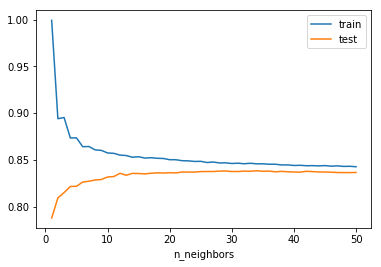

In [278]:
knn_adult_cc.plot()

In [303]:
knn_spam_cc = make_complexity_curve(KNeighborsClassifier(metric='euclidean', weights='uniform'), X_trans_spam_train, y_spam_train, "n_neighbors", np.arange(1,51,1),"knn_neighbors", "spam")

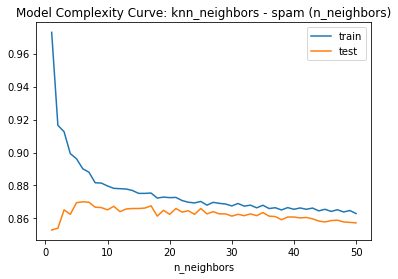

In [307]:
knn_spam_cc.plot(title=knn_spam_cc.name)

**Timing curve**

In [281]:
adult_timing = make_timing_curve_fixed(KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=15),X_trans_adult_train.astype(float), y_adult_train.astype(float),'knn_timing', 'adult')

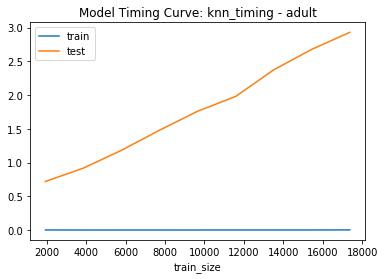

In [282]:
adult_timing.plot(title=adult_timing.name)

In [283]:
spam_timing = make_timing_curve_fixed(KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=15),X_trans_spam_train, y_spam_train,'knn_timing', 'spam')

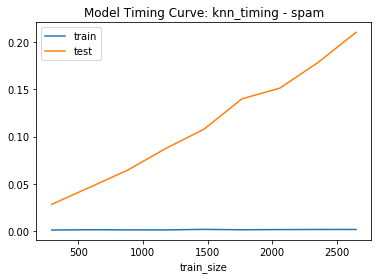

In [284]:
spam_timing.plot(title=spam_timing.name)

**Learning curve**

In [310]:
adult_lc = make_learning_curve(KNeighborsClassifier(metric='euclidean', n_neighbors=34),X_trans_adult_train.astype(float), y_adult_train.astype(float),np.linspace(0.1, 1.0, 10),'knn learning curve', 'adult')

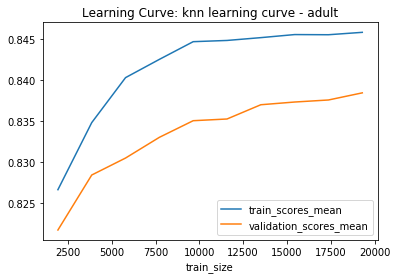

In [311]:
adult_lc.plot(title=adult_lc.name)

In [308]:
spam_lc = make_learning_curve(KNeighborsClassifier(metric='chebyshev', n_neighbors=23),X_trans_spam_train.astype(float), y_spam_train.astype(float),np.linspace(0.1, 1.0, 10),'knn learning curve', 'spam')

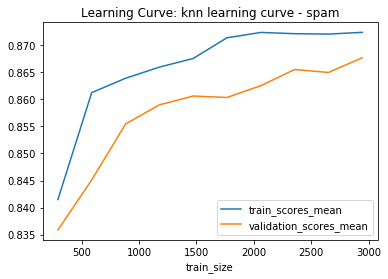

In [309]:
spam_lc.plot(title=spam_lc.name)

In [324]:
adult_cv.score(pipeAdult.transform(X_adult_test),y_adult_test)

0.8355710260235372

In [322]:
adult_cv.predict(pipeAdult.transform(X_adult_test)).shape

(6033,)

In [328]:
adult_cv.score(pipeAdult.transform(X_adult_test),y_adult_test)

0.8347422509530913